In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import cv2
import Comparison
import os

### Load Test Data

In [ ]:
gpu = 2
date_run = '240325Comp1'

In [2]:
datadir = '../dataset/0509/make14-split/'
print(os.listdir(datadir))

loaded
(7638, 2, 90, 100) (7638, 1, 128, 128)
6110 763 765
6110 763 765


In [ ]:
transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor()])

train_data = DS.MyDatasetV2(name = 'train',
                          paths = {'csi': datadir + 'fcsi_train.npy',
                                 'img': datadir + 'rimg_train.npy',
                                  'ind': datadir + 'ind_train.npy'},
                         transform = transform,
                         mmap_mode=None
                        )
train_data.load_data()
myloader = DS.DataSplitter(train_data, train_ratio=1)

train_loader = myloader.unsplit_loader()

valid_data = DS.MyDatasetV2(name = 'valid',
                          paths = {'csi': datadir + 'fcsi_valid.npy',
                                 'img': datadir + 'rimg_valid.npy',
                                  'ind': datadir + 'ind_train.npy'},
                         transform = transform,
                         mmap_mode=None
                        )
valid_data.load_data()
myloader = DS.DataSplitter(valid_data, train_ratio=0, valid_ratio=1)

valid_loader = myloader.unsplit_loader()

test_data = DS.MyDatasetV2(name = 'test',
                          paths = {'csi': datadir + 'fcsi_test.npy',
                                 'img': datadir + 'rimg_test.npy',
                                  'ind': datadir + 'ind_train.npy'},
                         transform = transform,
                         mmap_mode=None
                        )
test_data.load_data()
myloader = DS.DataSplitter(test_data, train_ratio=0, valid_ratio=0)

test_loader = myloader.unsplit_loader(shuffle=False)

In [3]:
transform = transforms.Compose([
    transforms.Resize([240, 320]),
    transforms.ToTensor()])
w_train_data = DS.MyDatasetV2(name = 'train',
                          paths = {'csi': datadir + 'fcsi_train.npy',
                                 'img': datadir + 'rimg_train.npy',
                                  'ind': datadir + 'ind_train.npy'},
                         transform = transform,
                         mmap_mode=None
                        )
w_train_data.load_data()
w_myloader = DS.DataSplitter(w_train_data, train_ratio=1)

w_train_loader = myloader.unsplit_loader()

w_valid_data = DS.MyDatasetV2(name = 'valid',
                          paths = {'csi': datadir + 'fcsi_valid.npy',
                                 'img': datadir + 'rimg_valid.npy',
                                  'ind': datadir + 'ind_train.npy'},
                         transform = transform,
                         mmap_mode=None
                        )
w_valid_data.load_data()
w_myloader = DS.DataSplitter(w_valid_data, train_ratio=0, valid_ratio=1)

w_valid_loader = myloader.unsplit_loader()

w_test_data = DS.MyDatasetV2(name = 'test',
                          paths = {'csi': datadir + 'fcsi_test.npy',
                                 'img': datadir + 'rimg_test.npy',
                                  'ind': datadir + 'ind_train.npy'},
                         transform = transform,
                         mmap_mode=None
                        )
w_test_data.load_data()
w_myloader = DS.DataSplitter(w_test_data, train_ratio=0, valid_ratio=0)

w_test_loader = myloader.unsplit_loader(shuffle=False)

loaded
(7638, 2, 90, 100) (7638, 1, 128, 128)
6110 763 765
6110 763 765


In [ ]:
select_ind = np.random.choice(765, 8).tolist()

### Load Models

#### Proposed

In [6]:
torch.cuda.set_device(gpu)
csiencoder = TP.CSIEncoder()
bbxdecoder = TP.BBXDecoder()
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)

imgencoder.load_state_dict(torch.load(f"../saved/240322R1/240322R1_Student_IMGENV06C2@ep200.pth"))
imgdecoder.load_state_dict(torch.load(f"../saved/240322R1/240322R1_Student_IMGDEV06C2@ep200.pth"))
csiencoder.load_state_dict(torch.load(f"../saved/240322R1/240322R1_Student_CSIENV06C2@ep200.pth"))
bbxdecoder.load_state_dict(torch.load(f"../saved/240322R1/240322R1_Student_BBXDEV06C2@ep200.pth"))

S_trainer = TP.StudentTrainer(
                              name='Student', mask=True,
    networks=[csiencoder, bbxdecoder, imgencoder, imgdecoder],
                 lr=1e-4, epochs=10, cuda=gpu,
                 train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader)

S_trainer.test(loader='test')
S_trainer.plot_test(select_num=8, autosave=True, notion=f"{date_run}Prop")

#### AutoEncoder

In [7]:
torch.cuda.set_device(gpu)
ae = TP.AutoEncoder(latent_dim=16)
ae.load_state_dict(torch.load('../saved/Comp_ae.pth'))

trainer_ae = TP.CompTrainer(name='AE', mode='ae', mask=True,
                              networks=[ae],
                 lr=1e-4, epochs=10, cuda=gpu,
                 train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader)

In [ ]:
trainer_ae.test(mode='test')
trainer_ae.plot_test(select_num=8, autosave=True, notion='240304Bench')

In [23]:
np.save('../saved/240304Bench/ae.npy', trainer_ae.loss.loss['pred']['LOSS'])

#### VAE

In [ ]:
torch.cuda.set_device(gpu)
imgdecoder = TP.ImageDecoder(latent_dim=16)
csiencoder = TP.CSIEncoder(out_length=32)
trainer_vae = TP.CompTrainer(name='VAE', mode='vae', mask=True,
                              networks=[csiencoder, imgdecoder],
                 lr=1e-4, epochs=10, cuda=gpu,
                 train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader)

In [ ]:
trainer_vae.test(mode='test')
trainer_vae.plot_test(select_ind=[0, 125, 250, 375, 500, 625, 750, 875],select_num=8, autosave=True, notion='240304Bench')

#### TS_AE

In [8]:
torch.cuda.set_device(gpu)
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)
csiencoder = TP.CSIEncoder(out_length=16)

trainer_ae_s = TP.CompTrainerStudent(
                              name='TSAE_Student', mask=True,
    networks=[csiencoder, imgencoder, imgdecoder],
                 lr=1e-4, epochs=10, cuda=gpu,
                 train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader)

In [ ]:
trainer_ae_s.test(loader=test_loader)
trainer_ae_s.plot_test(select_num=8, autosave=True, notion='240304Bench')

In [24]:
np.save('../saved/0829ts.npy', trainer_ts.test_loss['s']['IMG'])

#### Wi2Vi

In [9]:
torch.cuda.set_device(gpu)
wi2vi = TP.Wi2Vi()
wi2vi.load_state_dict(torch.load('../saved/0829r1/0829r1_Wi2Vi_e200.pth'))

trainer_wi2vi = TP.CompTrainer(name='Wi2Vi', mask=True,
                              networks=[wi2vi],
                 lr=1e-4, epochs=10, cuda=gpu,
                 train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader)

In [10]:
trainer_wi2vi.test(mode='test')
trainer_wi2vi.plot_test(select_ind=[0, 125,250,375,500,625,750,875],select_num=8, autosave=True, notion='240304Bench')

Student: test=612/765, loss=0.11455684155225754
Test finished. Average loss={'LOSS': 0.5105084423024475, 'STRA': 1.6379321341908055, 'DIST': 0.027326828888708764, 'IMG': 168.13128442452623}


In [25]:
np.save('../saved/0829wi2vi.npy', trainer_wi2vi.test_loss['LOSS'])

### Comparison

In [2]:
notion = '240401Comp1'
save_path = f'../saved/{notion}/'
figs = []

Proposed loading...
Proposed loaded Estimates of (8768, 128, 128) as float32
Reconstructing...OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

156 84 0 -47
Done
Reconstruction finished. Failure count = 1


<Figure size 432x288 with 0 Axes>

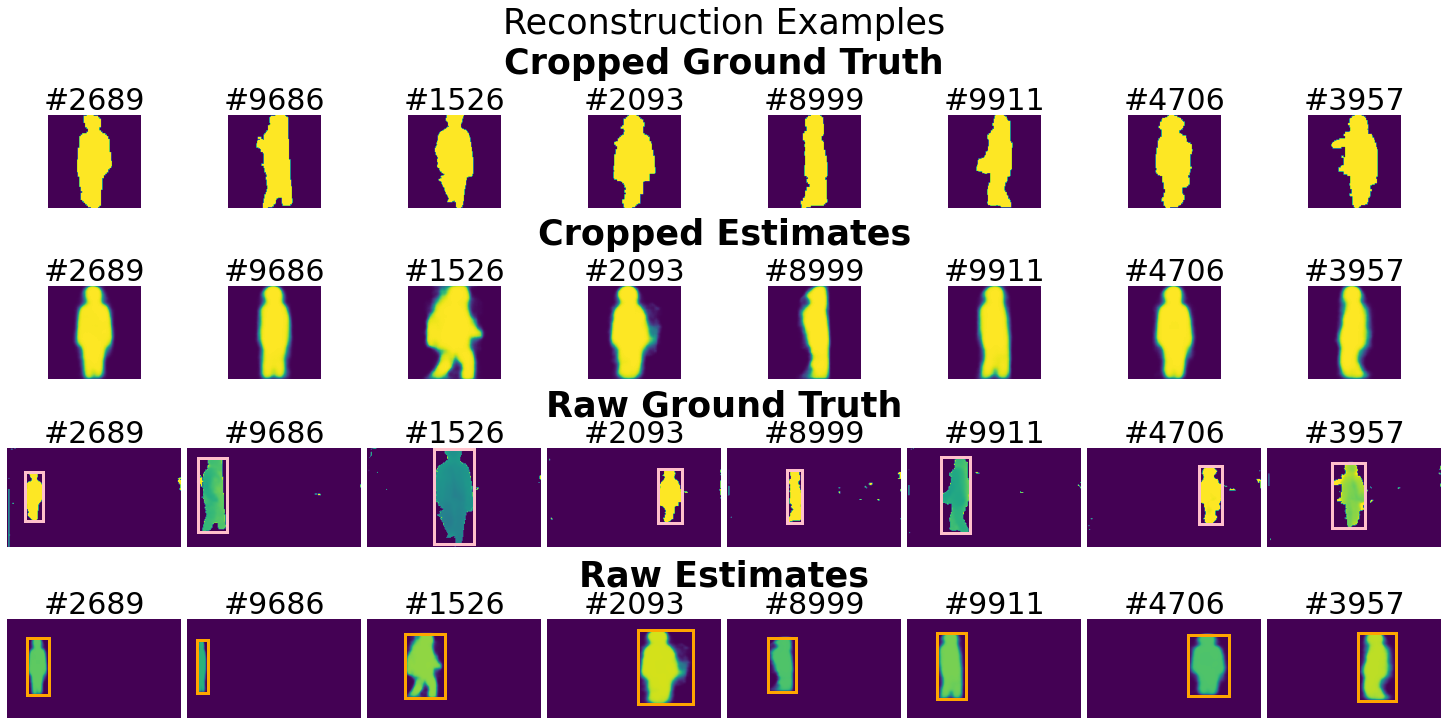

In [3]:
gt = np.squeeze(np.load('../dataset/0509/make14-split-few/rimg_test.npy', mmap_mode='r'))
gt_ind = np.load('../dataset/0509/make14-split-few/ind_test.npy', mmap_mode='r')

proposed = Comparison.PropResultCalculator('Proposed', '../saved/240331R1Prop/240331R1Prop_Student_pred.npy', gt, gt_ind)
proposed.resize()
figs.append(proposed.plot_example())

In [4]:
ae = Comparison.ResultCalculator('AE', '../saved/240331R1AE/240331R1AE_AE_pred.npy', gt, gt_ind)
vae = Comparison.ResultCalculator('VAE', '../saved/240331R1VAE/240331R1VAE_VAE_pred.npy', gt, gt_ind)
ts_ae = Comparison.ResultCalculator('TS-AE', '../saved/240331R1TSAE/240331R1TSAE_Student_pred.npy', gt, gt_ind)
wi2vi = Comparison.ResultCalculator('Wi2Vi', '../saved/240331R1Wi2Vi/240331R1Wi2Vi_Wi2Vi_pred.npy', gt, gt_ind)
ts_vae = Comparison.ResultCalculator('TS-VAE', '../saved/240331R1TSVAE/240331R1TSVAE_Student_pred.npy', gt, gt_ind)

AE loading...
AE loaded Estimates of (8792, 128, 128) as float32
VAE loading...
VAE loaded Estimates of (8792, 128, 128) as float32
TS-AE loading...
TS-AE loaded Estimates of (8792, 128, 128) as float32
Wi2Vi loading...
Wi2Vi loaded Estimates of (8792, 240, 320) as float32
TS-VAE loading...
TS-VAE loaded Estimates of (8792, 128, 128) as float32


AE resizing...Done!
VAE resizing...Done!
TS-AE resizing...Done!
TS-VAE resizing...Done!
Wi2Vi resizing...Done!


<Figure size 432x288 with 0 Axes>

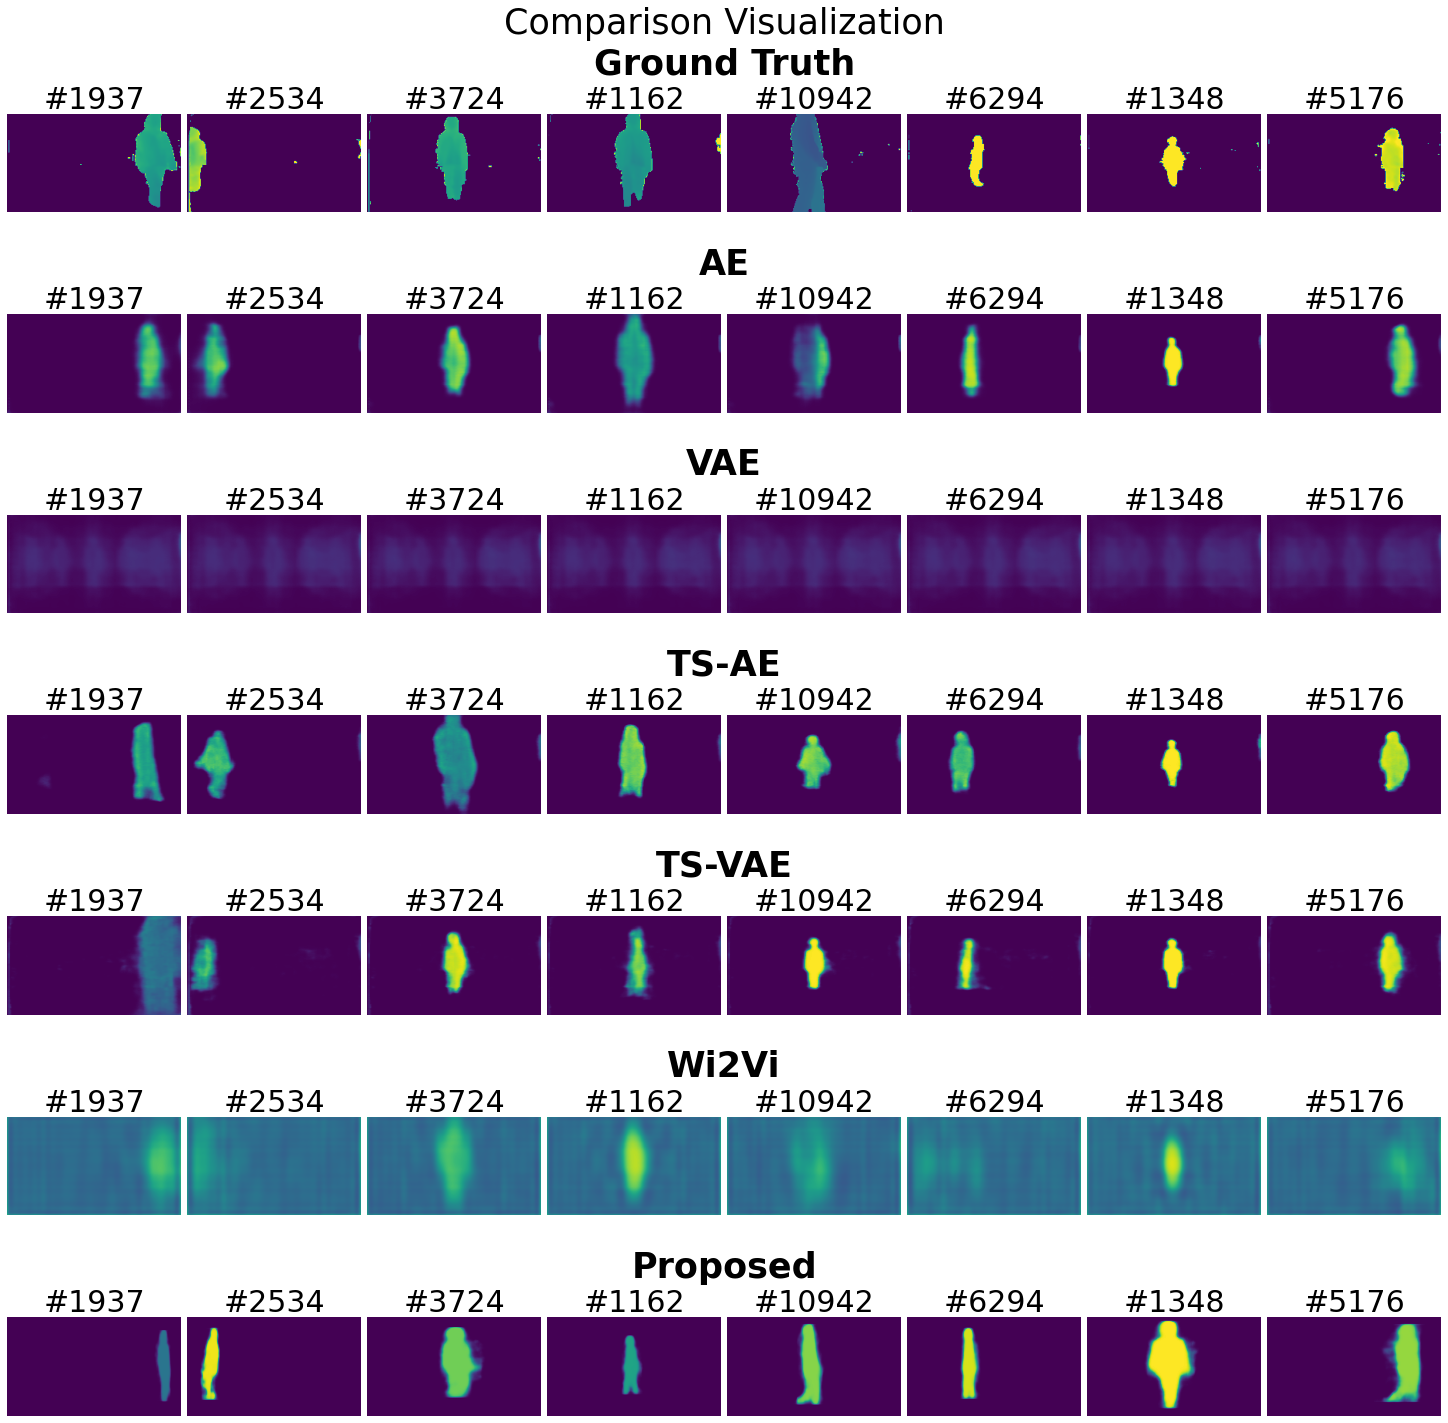

In [5]:
%matplotlib inline
for comp in (ae, vae, ts_ae, ts_vae, wi2vi):
    comp.resize()
figs.append(Comparison.visualization(ae, vae, ts_ae, ts_vae, wi2vi, proposed, figsize=(20, 20)))

AE calculating loss...

/home/bob/datastore/Models/Comparison.py:41: UserWarning: Using a target size (torch.Size([1, 128, 226])) that is different to the input size (torch.Size([128, 226])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.result[i] = F.mse_loss(pred, torch.from_numpy(self.gt[_ind]))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
AE calculating histograms...Done!


<Figure size 1440x1440 with 0 Axes>

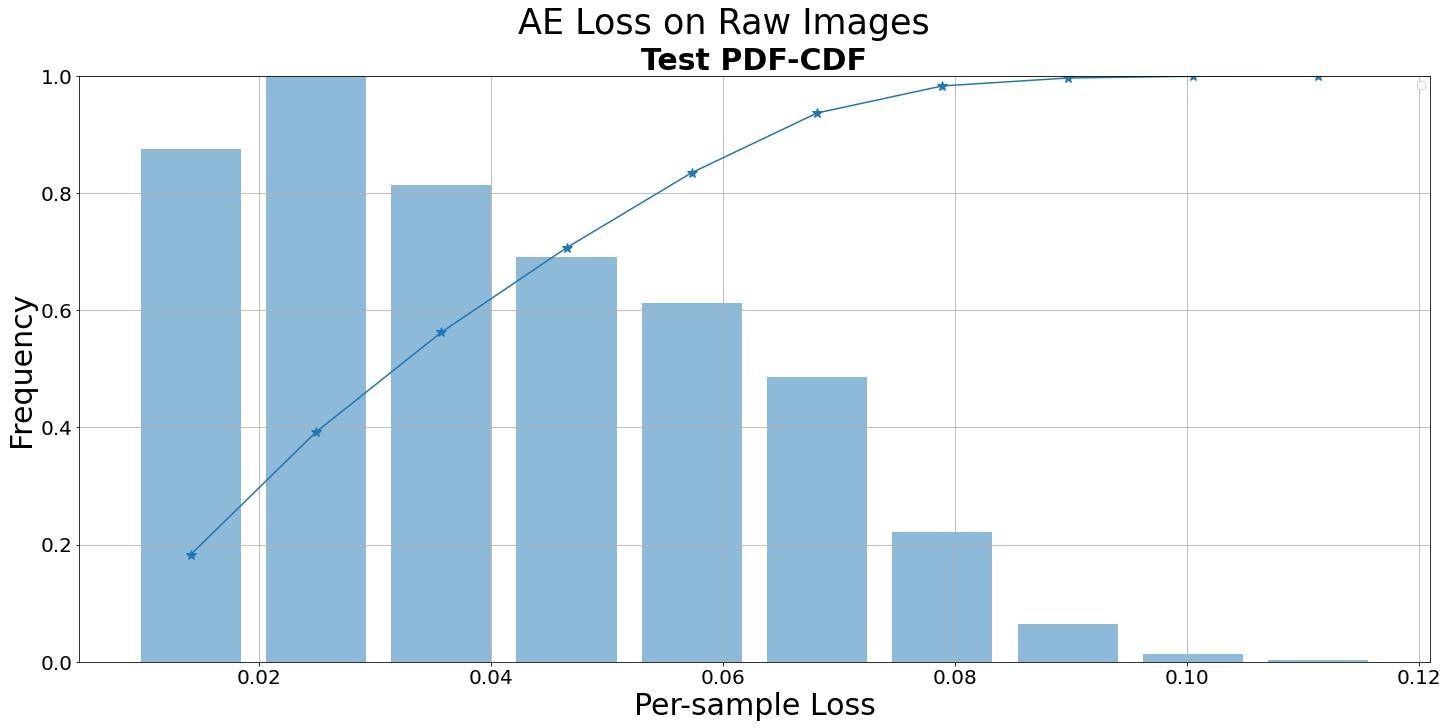

VAE calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
VAE calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

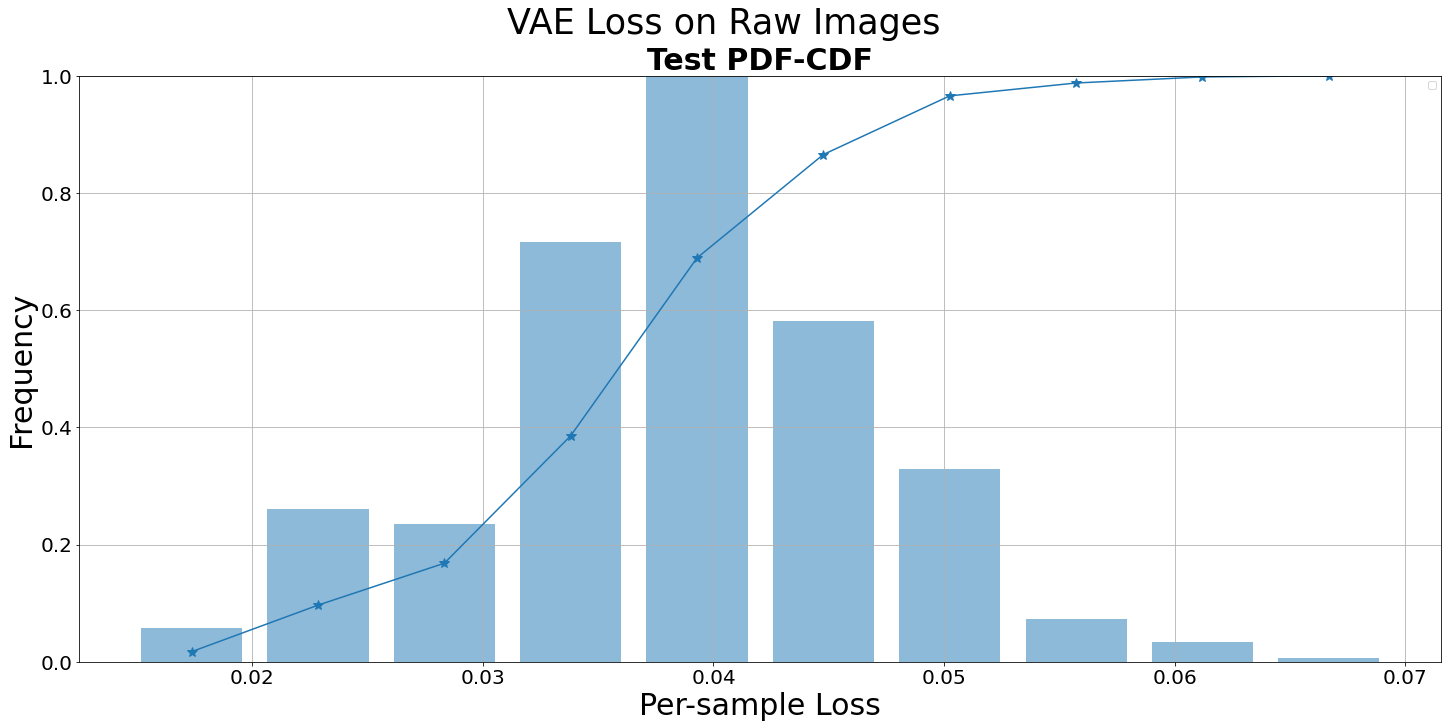

TS-AE calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
TS-AE calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

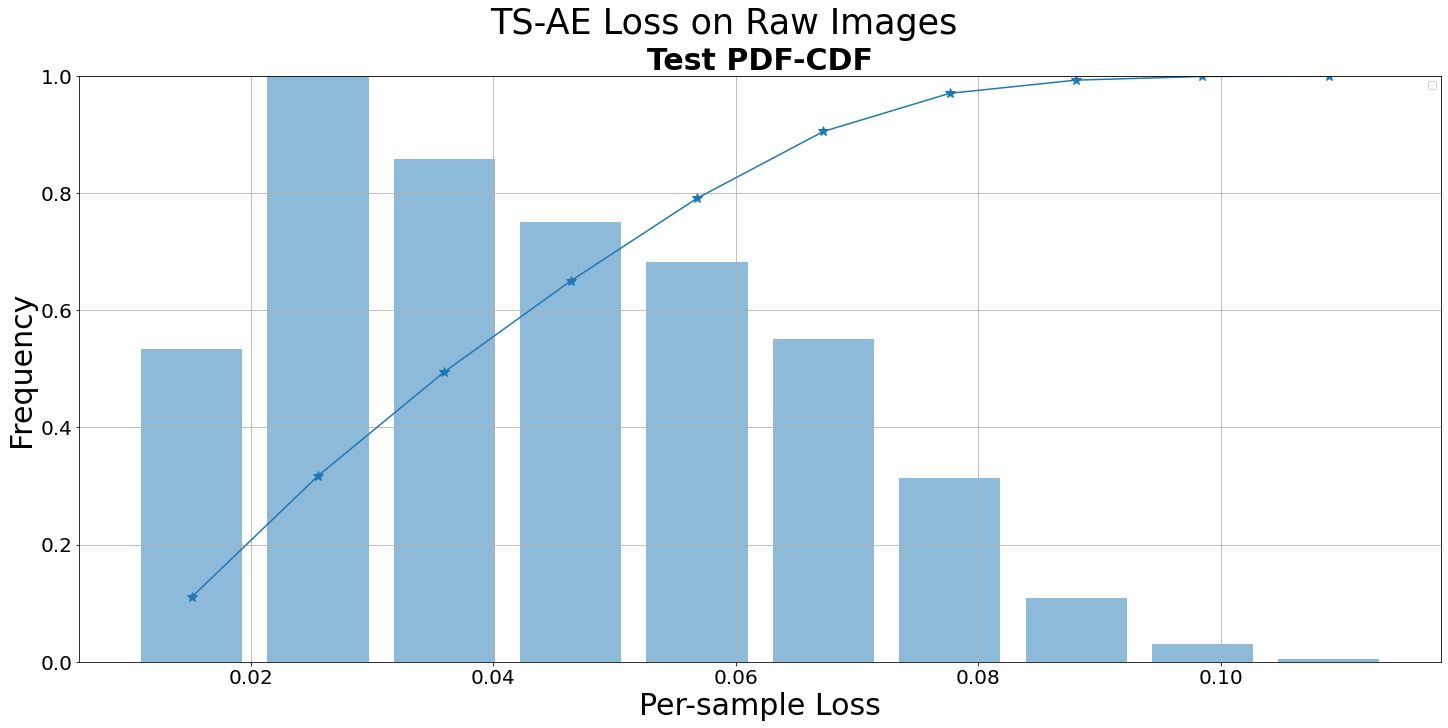

TS-VAE calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
TS-VAE calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

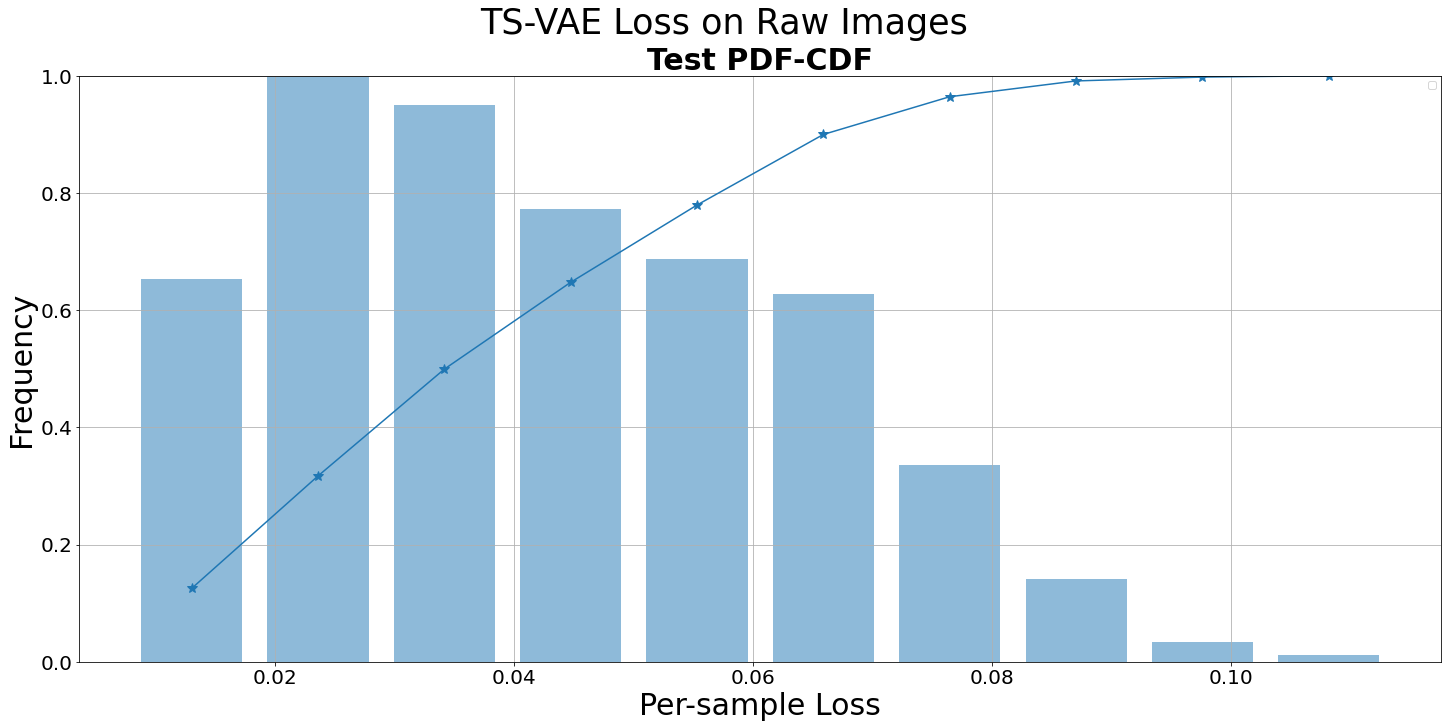

Wi2Vi calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
Wi2Vi calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

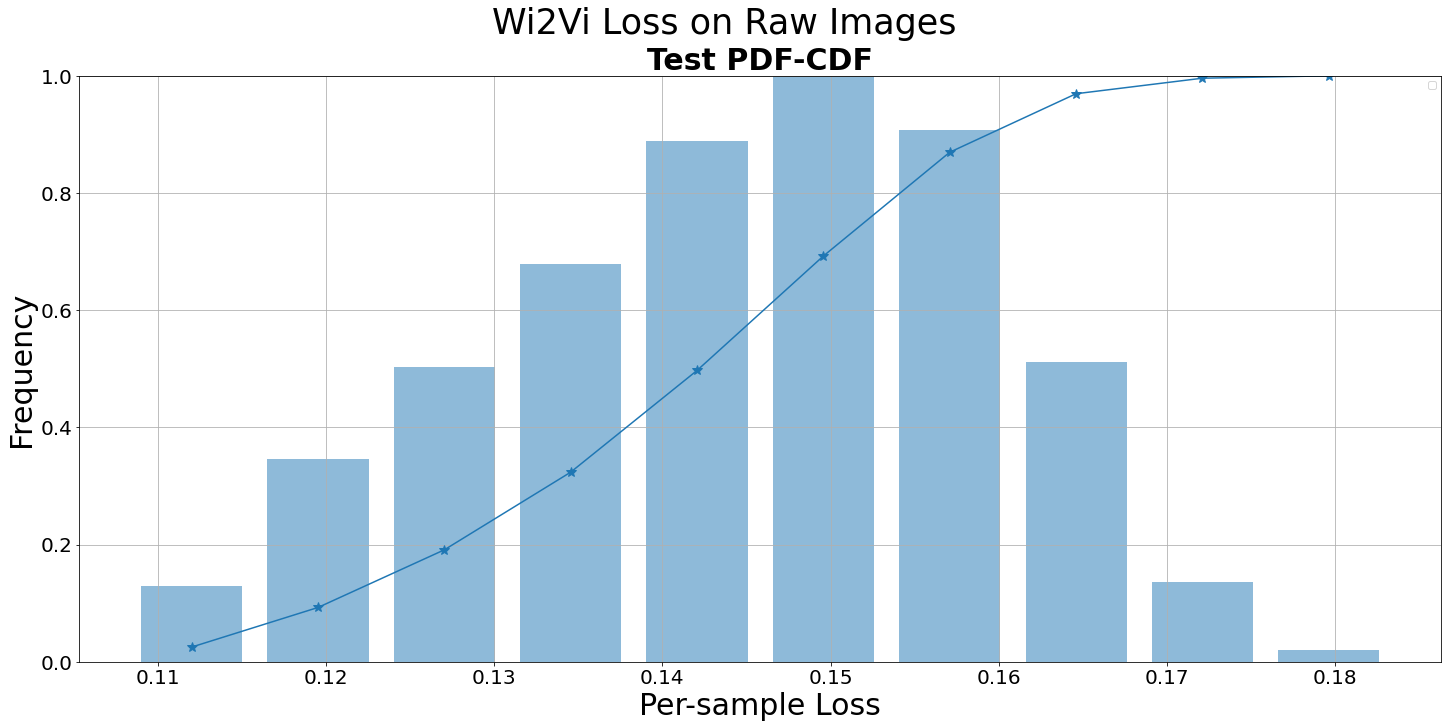

Proposed calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
Proposed calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

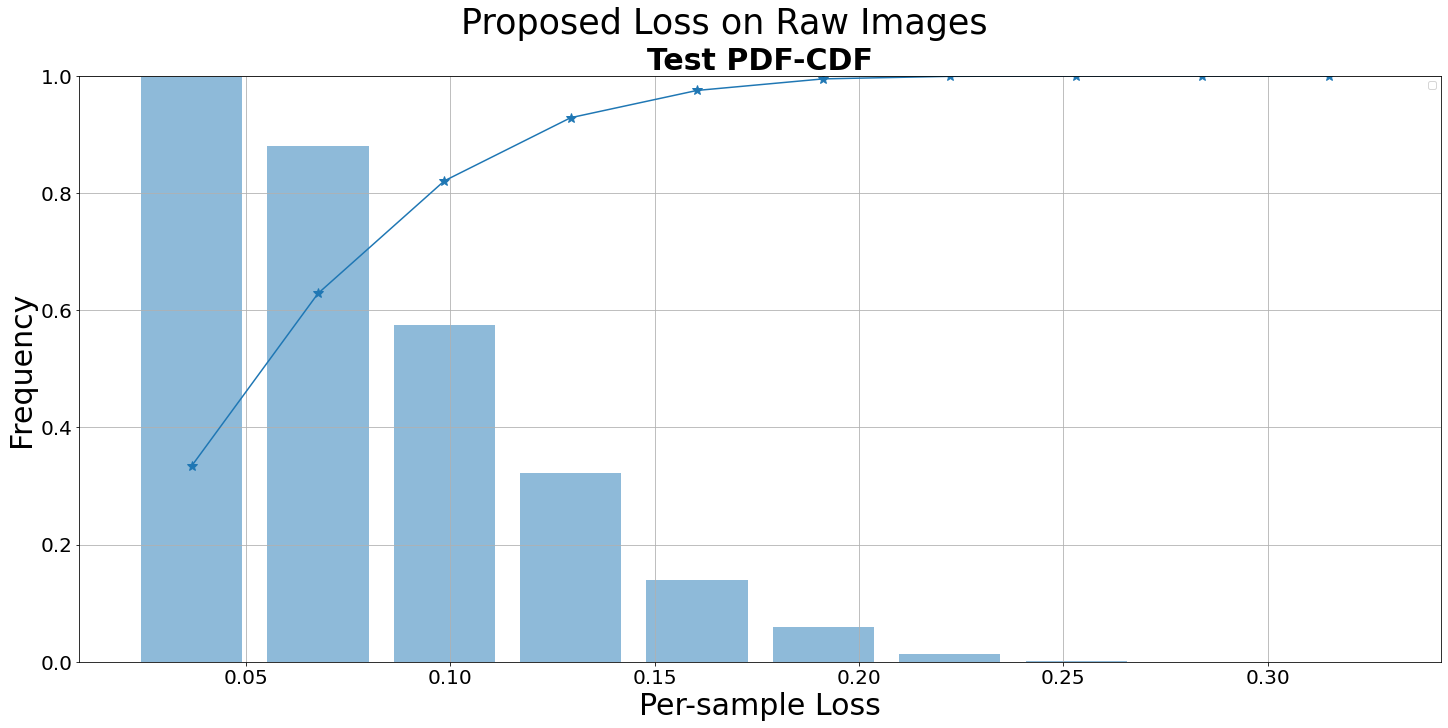

In [6]:
for method in(ae, vae, ts_ae, ts_vae, wi2vi, proposed):
    method.calculate_loss()
    fig, filename = method.calculate_cdf()

<Figure size 1440x720 with 0 Axes>

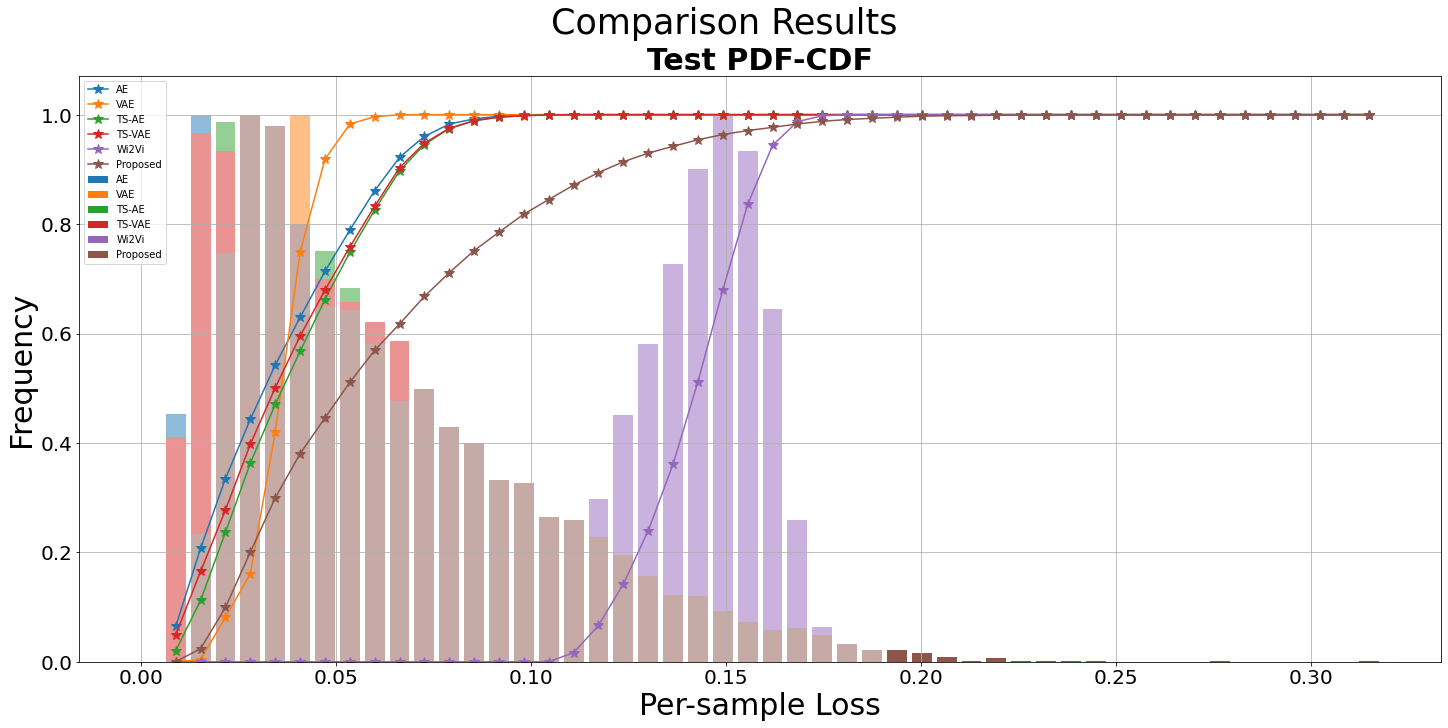

In [7]:
figs.append(Comparison.gather_plot(ae, vae, ts_ae, ts_vae, wi2vi, proposed))

In [9]:
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)
for fig, filename in figs:
    fig.savefig(f"{save_path}{notion}_{filename}")